# Scenario1.2 - Wasterwater
We are asked to explore the use of wastewater-based data as an observalbe in a model.

### Question 1a - Previous Work

These two pre-prints emply wastewater data in their models:

- https://www.medrxiv.org/content/10.1101/2021.10.19.21265221v1.full.pdf (Fazli et al.)
- https://www.medrxiv.org/content/10.1101/2020.11.05.20226738v1.full.pdf (MacMahan et al.)

Both papers employ a SEIR model with their individal tweaks.

## Question 1b - compare models
### Fazli et al. SEIR Model
In Fazli et al., the SEIR model has an initial birthrate that expands the susceptible population and two observation states that correpsond to the measured count of SARS-CoV-2 RNA in the wastewater and reported cases, respectively.

In [1]:
import sympy
import itertools
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling.viz import GraphicalModel

In [2]:
# Define units and symbols
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
person_per_day_units = lambda: Unit(expression=sympy.Symbol('person')/sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))
per_person_units = lambda: Unit(expression=1/sympy.Symbol('person'))

S, E, I, R, V, Y, N, kappa, beta, beta_s, beta_c, k, t_0, t, alpha, delta, rho, gamma, rho_V, rho_Y, br, iota, mu_EI, mu_IR, tau, T_0, tau_star_0, V_0, Q_0 = \
    sympy.symbols('S E I R V Y N kappa beta beta_s beta_c k t_0 t alpha delta rho gamma rho_V rho_Y br iota mu_EI mu_IR tau T_0 tau_star_0 V_0 Q_0')


In [3]:
# Setup
# FIXME: use the proper rate values and symbols from the paper
concepts_fazli = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    # Maybe the count for V is RNA snippets?
    'V': Concept(name='V', units=dimensionless_units(), identifiers={"chebi": "33697"}),  # RNA
    'Y': Concept(name='Y', units=dimensionless_units(), identifiers={"cemo": "number_of_cases_by_testing"}),
}

P = 50_000
N_0_fazli = 0.05*P

parameters_fazli = {
    # alpha is a mixing parameter in this model and used as an exponent
    'alpha': Parameter(name='alpha', value=1.07, units=dimensionless_units()),
    'N': Parameter(name='N', value=N_0_fazli, units=person_units()),
#     't_0': Parameter(name='t_0', value=89, unts=day_units, units=day_units()),
#     'kappa': Parameter(name='kappa', value=5/11, units=per_day_units()),
#     'k': Parameter(name='k', value=5.0, units=dimensionless_units()),
    'iota': Parameter(name='iota', value=4.27, units=person_units()),
    'mu_EI': Parameter(name='mu_EI', value=1/6, units=per_day_units()),
    'mu_IR': Parameter(name='mu_IR', value=1/7.7, units=per_day_units()),
    'rho_V': Parameter(name='rho_V', value=3760, units=per_person_units()),
    'rho_Y':  Parameter(name='rho_Y', value=0.14, units=per_person_units()),
    'br': Parameter(name='br', value=7.68, units=person_units())
}

initials_fazli = {
    'S': Initial(concept=Concept(name='S'), value=0.95*N_0_fazli),
    'E': Initial(concept=Concept(name='E'), value=0.04*N_0_fazli),
    'I': Initial(concept=Concept(name='I'), value=0.01*N_0_fazli),
    'R': Initial(concept=Concept(name='R'), value=0),
    'V': Initial(concept=Concept(name='V'), value=0), # Verify with paper
    'Y': Initial(concept=Concept(name='Y'), value=0), # Verify with paper
}

# FIXME
# Might want to spell out the reported cases, Y, as a function of I?
# and wastewater, V, as a function of E and I?
observables_fazli = {
    'wastewater_rna': Observable(name='wastewater_rna', expression=SympyExprStr(V)),
    'reported_cases': Observable(name='reported_cases', expression=SympyExprStr(rho_V*I))
}

In [4]:
# model creation
# FIXME: fix rates

# Full equation also multiplies with a Gamma white noise here
# Infection rate, see equation 15 in Fazli et al.
mu_SE = beta*(I+iota)**alpha/N

# Birthrate/people entering a susceptible state from 
# the outside population
t0 = NaturalProduction(outcome=concepts_fazli['S'],
                       rate_law=br)
# Exposure
t1 = ControlledConversion(subject=concepts_fazli['S'],
                          outcome=concepts_fazli['E'],
                          controller=concepts_fazli['I'],
                          rate_law=mu_SE)
# Infection
t2 = NaturalConversion(subject=concepts_fazli['E'],
                       outcome=concepts_fazli['I'],
                       rate_law=mu_EI*E)
# Removal/recovery
t3 = NaturalConversion(subject=concepts_fazli['I'],
                       outcome=concepts_fazli['R'],
                       rate_law=mu_IR*I)
# Shedding; both E and I shed
t4 = GroupedControlledProduction(
    controllers=[concepts_fazli["E"], concepts_fazli["I"]],
    outcome=concepts_fazli["V"],
    rate_law=rho_V*(E+I),  # Verify with paper
)
# Testing/case - people from I are tested at a rate of rho_Y per day
# t5 = ControlledProduction(
#     controller=concepts['I'],
#     outcome=concepts['Y'],
#     rate_law=rho_Y*I, # Verfiy with paper
# )
templates_fazli = [t0, t1, t2, t3, t4]#, t5]
tm_fazli = TemplateModel(
    templates=templates_fazli,
    initials=initials_fazli,
    time=Time(name='t', units=day_units()),
    observables=observables_fazli,
    annotations=Annotations(name='Scenario 1 q2 fazli')
)
AskeNetPetriNetModel(Model(tm_fazli)).to_json_file('scenario1_q2_fazli.json')
tm_fazli.observables

{'wastewater_rna': Observable(name='wastewater_rna', display_name=None, description=None, identifiers={}, context={}, units=None, expression=V),
 'reported_cases': Observable(name='reported_cases', display_name=None, description=None, identifiers={}, context={}, units=None, expression=I*rho_V)}

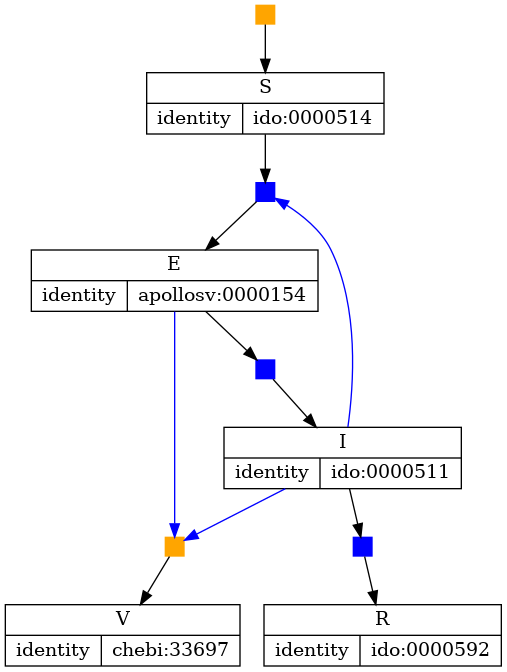

In [5]:
GraphicalModel.for_jupyter(tm_fazli)

### McMahan et al. SEIR Model
In McMahan et al., the SEIR model only has one observation state correpsonding to the measured count of SARS-CoV-2 RNA in the wastewater. There is also no birth process that expands the susceptible population 

In [6]:
# Setup
# FIXME: use the proper rate values and symbols from the paper
concepts_mcmahan = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    'V': Concept(name='V', units=dimensionless_units(), identifiers={"chebi": "33697"}),
    'Y': Concept(name='Y', units=dimensionless_units(), identifiers={"cemo": "number_of_cases_by_testing"}),
}

N_0_mcmahan = 25_000

parameters_mcmahan = {
    # fixme: get the final beta of the paper, they tried several
    'beta': Parameter(name='beta', value=1/5, units=per_day_units()),
    'gamma': Parameter(name='gamma', value=1/10, units=per_day_units()),
    'delta': Parameter(name='delta', value=1/5, units=per_day_units()),
#     'alpha': Parameter(name='alpha', value=1/5, units=per_day_units()),
#     'rho': Parameter(name='rho', value=1/9, units=per_day_units()),
    'N': Parameter(name='N', value=N_0_mcmahan, units=person_units()),
    't_0': Parameter(name='t_0', value=89, unts=day_units, units=day_units()),
    # D=11, gamma = 1/D, R_0 = 5 and
    # beta = R_0 * gamma * mask(t) so kappa = 5/11
    'kappa': Parameter(name='kappa', value=5/11, units=per_day_units()),
    'k': Parameter(name='k', value=5.0, units=dimensionless_units()),
}

# FIXME: use the proper rate values and symbols from the paper
initials_mcmahan = {
    'S': Initial(concept=Concept(name='S'), value=0.9999*N_0_mcmahan),
    'E': Initial(concept=Concept(name='E'), value=0.00005*N_0_mcmahan),
    'I': Initial(concept=Concept(name='I'), value=0.00005*N_0_mcmahan),
    'R': Initial(concept=Concept(name='R'), value=0),
    'V': Initial(concept=Concept(name='V'), value=0),
}
# Rely on symbols created earlier
# FIXME
# The function for V is very complicated

T = 280  # Current wastewater temperature
tau_star = tau_star_0*Q_0**((T-T_0)/10)
V = V_0*0.5**(tau/tau_star)

# Add to symbols: T_0, tau_star_0, V_0
observables_mcmahan = {
    'reported_cases': Observable(
        name='reported_cases',
        expression=V)
}


In [7]:
# model creation
# FIXME: fix rates

# Exposure
t1 = ControlledConversion(subject=concepts_mcmahan['S'],
                          outcome=concepts_mcmahan['E'],
                          controller=concepts_mcmahan['I'],
                          rate_law=S*I*beta)
# Infection/Illness 
t2 = NaturalConversion(subject=concepts_mcmahan['E'],
                       outcome=concepts_mcmahan['I'],
                       rate_law=alpha*E)
# Removal/recovery
t3 = NaturalConversion(subject=concepts_mcmahan['I'],
                       outcome=concepts_mcmahan['R'],
                       rate_law=gamma*I)

templates_mcmahan = [t1, t2, t3]
tm_mcmahan = TemplateModel(
    templates=templates_mcmahan,
    parameters=parameters_mcmahan,
    initials=initials_mcmahan,
    time=Time(name='t', units=day_units()),
    observables=observables_mcmahan,
    annotations=Annotations(name='Scenario 1 q2 mcmahan')
)
AskeNetPetriNetModel(Model(tm_mcmahan)).to_json_file('scenario1_q2_mcmahan.json')
tm_mcmahan.observables

{'reported_cases': Observable(name='reported_cases', display_name=None, description=None, identifiers={}, context={}, units=None, expression=0.5**(Q_0**(T_0/10 - 28)*tau/tau_star_0)*V_0)}

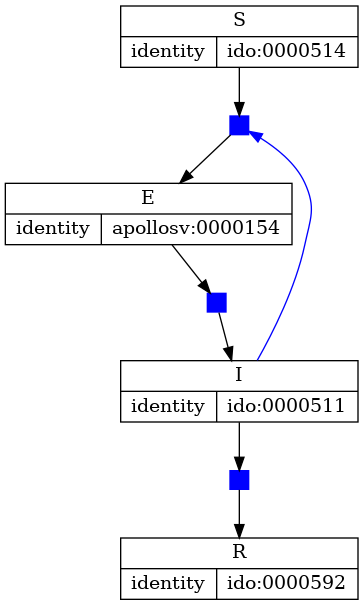

In [8]:
GraphicalModel.for_jupyter(tm_mcmahan)

### Model comparison
Compare the two models

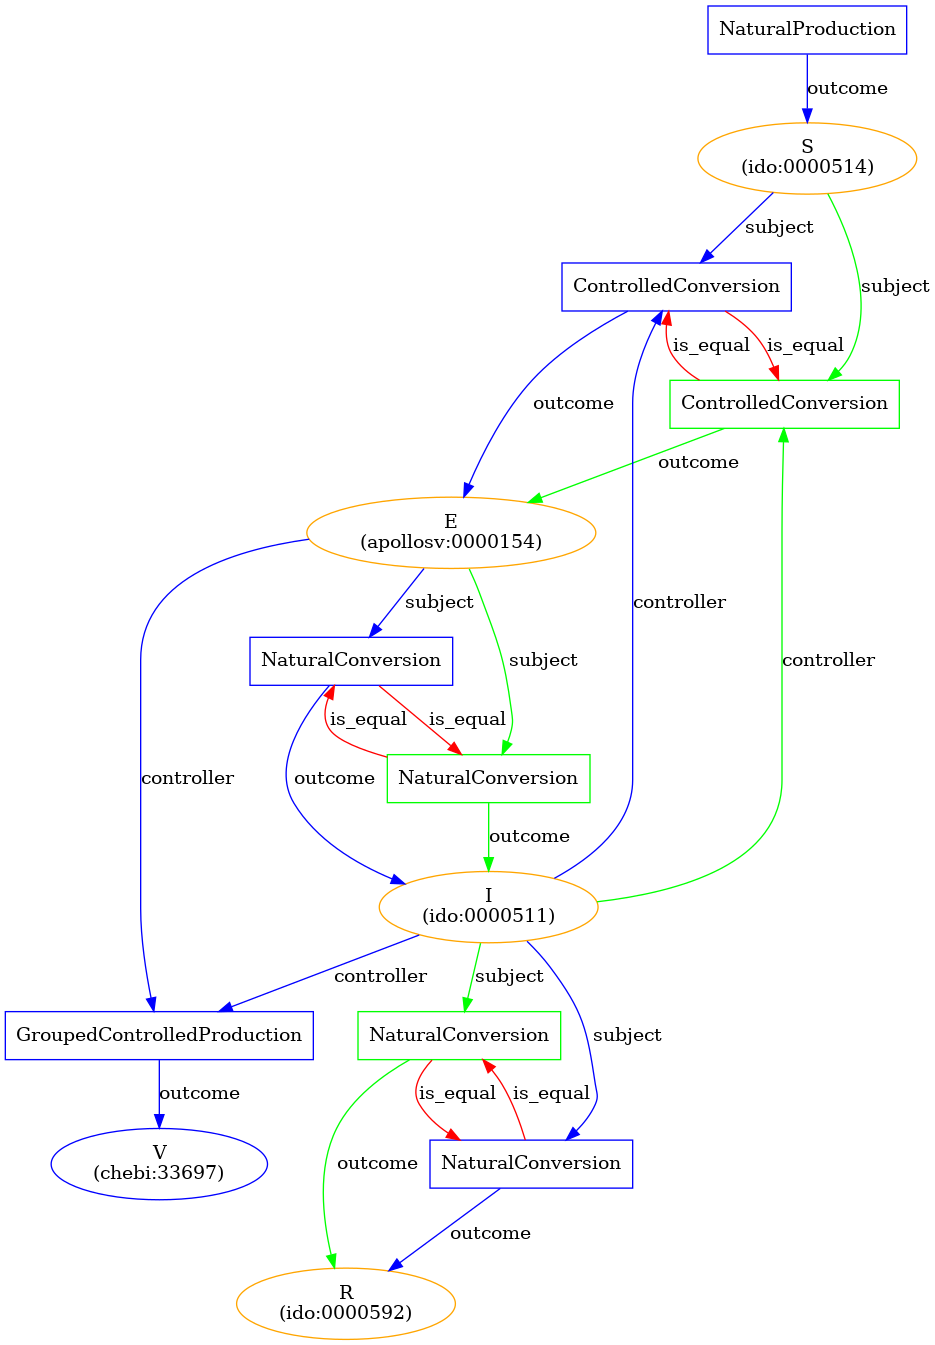

In [9]:
from mira.metamodel.comparison import TemplateModelDelta
from mira.dkg.web_client import is_ontological_child_web
TemplateModelDelta.for_jupyter(
    template_model1=tm_fazli,
    template_model2=tm_mcmahan,
    refinement_function=is_ontological_child_web,
    name='Scenario 1 q2 b compare.png',
    args="-Grankdir=TB"
)

Fazli et al. employ two observables, viral load in wastewater and reported cases, while McMahan use only wastewater measurements.

McMahan uses a time dependent shedding mechanism, as opposed to a constant rate of shedding in Fazli et al.